# introduction to the vectorizing principle

## part 6: many ways to describe data transformations in python

We have seen that both SQL databases and DataFrames are powerful tools to perform data transformations.
In python, several libraries exist for this task with their own strengths and weaknesses:

- [Pandas](https://pandas.pydata.org/) is the most popular library for working with DataFrames in python. However, it got extremely popular before its API design could be completed to an extent that it would avoid serious pitfalls in day-to-day code. Since it is that widely used and some problems are caused by core principles of the library, it cannot be expected that such problems just vanish by waiting long enough.
- [Polars](https://www.pola.rs/) is a contender in the DataFrame space with fastly growing popularity. Its core implementation is in Rust and it has a modern architecture allowing for lazy expression building and optimized execution.
- [Pydiverse.transform](https://github.com/pydiverse/pydiverse.transform/) was used in part 5 and can be used to work on DataFrames and SQL databases with the same syntax. While it is still an early stage open source project, the ambition is to provide the highest reliability of all tools targeting DataFrame and SQL execution backends for a defined set of most relevant data transformation operations.
- [Ibis](https://ibis-project.org/) is a library that also tries to abstract the data transformation description from execution backends with a predominant focus on generating SQL expressions. While it already supports a wide range of operations and SQL dialects, there still seem to be some reliability issues which seem hard to fix given the current architecture.
- [SQLAlchemy](https://www.sqlalchemy.org/) is the most widely used library for generating SQL expression with python code. However, its syntax has rough edges and is much less concise compared with the other tools.
- SQL query strings can still be handwritten and form a powerful interface for describing data transformations in an ad-hoc fashion.

It may be worth noting, that a pretty clean way of describing tabular data transformations was developed for the programming language R called [dplyr](https://dplyr.tidyverse.org/). It is the basis of the API design of various python libraries like pydiverse.transform, ibis, and tidypolars. So even if you do not intend to work with the programming language R, it is worth reading the [dplyr](https://dplyr.tidyverse.org/) documentation since it is a nice introduction to the field in general.

#### the following code shows how to describe the join of two tables and adding a new column to the result works in different libraries:


In [1]:
import os

import pandas as pd
import polars as pl
import sqlalchemy as sa
import ibis
import pydiverse.transform as pdt
from pydiverse.pipedag import Flow, Stage, Table, materialize
from pydiverse.transform.core.verbs import (
    left_join,
    mutate,
    select, alias,
)
from pydiverse.transform.eager import PandasTableImpl
from pydiverse.transform.lazy import SQLTableImpl


@materialize(input_type=pd.DataFrame, version="1.0.0")
def task_pandas(a: pd.DataFrame, b: pd.DataFrame):
    return a.merge(b, on="pk", how="left").assign(x2=lambda df: df.x * df.x)


@materialize(input_type=pl.DataFrame, version="1.0.0")
def task_polars(a: pl.DataFrame, b: pl.DataFrame):
    x = pl.col("x")
    return a.join(b, on="pk", how="left").with_columns((x * x).alias("x2"))


@materialize(input_type=PandasTableImpl, version="1.0.0")
def task_transform_df(a: pdt.Table, b: pdt.Table):
    return (
        a >> left_join(b, pk_match(a, b)) >> mutate(x2=b.x * b.x)
        >> alias("transform_df")
    )


@materialize(input_type=SQLTableImpl, lazy=True)
def task_transform_sql(a: pdt.Table, b: pdt.Table):
    return (
        a >> left_join(b, pk_match(a, b)) >> mutate(x2=b.x * b.x)
        >> alias("transform_sql")
    )


@materialize(input_type=ibis.api.Table, lazy=True)
def task_ibis(a: ibis.api.Table, b: ibis.api.Table):
    return a.left_join(b, pk_match(a, b)).mutate(x2=b.x * b.x)


@materialize(input_type=sa.Table, lazy=True)
def task_sqlalchemy(a: sa.Table, b: sa.Table):
    return sa.select(
        *a.c,
        *[c for c in b.c if c.name not in a.c],
        (b.c.x * b.c.x).label("x2"),
    ).select_from(a.outerjoin(b, pk_match_sa(a, b)))


@materialize(input_type=sa.Table, lazy=True)
def task_sql(a: sa.Table, b: sa.Table):
    return sa.text(f"""
        SELECT
            a.*,
            b.*,
            b.x * b.x AS x2
        FROM {a.original.schema}.{a.name} AS a
        LEFT JOIN {b.original.schema}.{b.name} AS b
        ON a.pk = b.pk
    """)

#### define remaining tasks and helper functions

In [2]:
@pdt.verb
def transmute(tbl, **kwargs):
    return tbl >> select() >> mutate(**kwargs)


@pdt.verb
def trim_all_str(tbl):
    for col in tbl:
        if col._.dtype == "str":
            tbl[col] = col.strip()
    return tbl


def pk(x: pdt.Table):
    # This is just a placeholder.
    # Ideally there would be a global function in pydiverse transform to
    # get the primary key (and another one to get the table / col name)
    return x.pk


def pk_match(x: pdt.Table, y: pdt.Table):
    return pk(x) == pk(y)


def pk_match_sa(x: sa.Table, y: sa.Table):
    # # we lost the primary_key already or duckdb cannot reflect it
    # cond = sa.literal(True)
    # for col in y.original.primary_key:
    #     if col not in x.c:
    #         cond &= x.c[col] == y.c[col]
    return x.c.pk == y.c.pk  # hack: assume primary key is always on column pk

def get_named_tables(tables: list[pdt.Table]) -> dict[str, pdt.Table]:
    return {tbl._impl.name: tbl for tbl in tables}


@materialize(version="1.0.0")
def read_input_data(src_dir="data/pipedag_example_data"):
    return [
        Table(pd.read_csv(os.path.join(src_dir, file)), name=file.removesuffix(".csv.gz"))
        for file in os.listdir(src_dir)
        if file.endswith(".csv.gz")
    ]


@materialize(input_type=SQLTableImpl, lazy=True, nout=3)
def clean(src_tbls: list[pdt.Table]):
    out_tbls = [tbl >> trim_all_str() for tbl in src_tbls]
    named_tbls = get_named_tables(out_tbls)
    a = named_tbls["a"]
    b = named_tbls["b"]
    c = named_tbls["c"]
    return a, b, c


@materialize(input_type=ibis.api.Table, version="1.0.0")
def check_x2_sum(tbls: list[ibis.api.Table]):
    all_x2_sum = None
    for tbl in tbls:
        x2_sum = tbl.x2.sum().to_pandas()
        if all_x2_sum is None:
            all_x2_sum = x2_sum
        else:
            assert x2_sum == all_x2_sum


#### define pipeline:

In [3]:
def get_pipeline():
    tasks = [task_pandas, task_polars, task_transform_df, task_transform_sql,
             task_ibis, task_sqlalchemy, task_sql]
    with Flow("flow") as flow:
        with Stage("x1_raw_input"):
            raw_tbls = read_input_data()

        with Stage("x2_clean_input"):
            a, b, c = clean(raw_tbls)

        with Stage("x3_transformed_data"):
            out_tbls = [task(a, b) for task in tasks]

        with Stage("x4_check"):
            check_x2_sum(out_tbls)

    return flow

#### setup logging:

In [4]:
import logging
from pydiverse.pipedag.util.structlog import setup_logging
setup_logging(log_level=logging.INFO)

#### run pipeline:

2023-08-08 13:29:30.131052 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/pipedag/vectorization/db.duckdb schema_prefix= schema_suffix=
2023-08-08 13:29:30.139182 [info     ] Starting IPCServer             [RunContextServer] address=tcp://127.0.0.1:34283
2023-08-08 13:29:30.142004 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/pipedag/vectorization/db.duckdb schema_prefix= schema_suffix=
2023-08-08 13:29:30.189611 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    CREATE SCHEMA IF NOT EXISTS pipedag_metadata
2023-08-08 13:29:30.220354 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    CREATE SCHEMA IF NOT EXISTS x1_raw_input
2023-08-08 13:29:30.221408 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    DROP SCHEMA IF EXISTS x1_raw_input__even CASCADE
2023-08-08 13:29:30.228556 [info     ] Executing sql                  [Duc

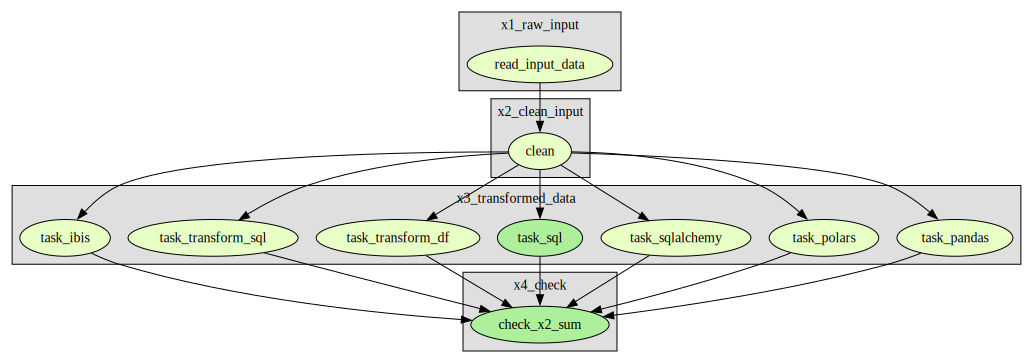

In [5]:
flow = get_pipeline()
result = flow.run()
result.visualize()
assert result.successful